# Compare Speed vs Accuracy
Compare the fidelity of different computation methods to computational cost

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from qcelemental.models import Molecule
from sklearn.metrics import r2_score, mean_absolute_error
from scipy.stats import siegelslopes
from timeout_decorator import timeout
from timeout_decorator import TimeoutError as TException
from tqdm import tqdm
from networkx import NetworkXError
import pandas as pd
import numpy as np
import json

## Load in the Baseline Datasets
We use the NIST WebBook and Gaussian G4MP2 as comparison

In [2]:
nist_ip = pd.read_json('nist-srd/ie.jsonld', lines=True)
nist_ea = pd.read_json('nist-srd/ea.jsonld', lines=True)

In [3]:
gaussian = pd.read_csv('datasets/gaussian-redox.csv')

## Load in the Computation Datasets
Get the methods we are comparing

In [4]:
xtb = pd.read_csv('datasets/xtb_redox.csv', index_col='inchi')

Calculations with few approximations

In [5]:
smb_nwchem = pd.read_csv('datasets/small-basis_redox.csv', index_col='inchi')
nob_nwchem = pd.read_csv('datasets/normal-basis_redox.csv', index_col='inchi')

Calculations where we neglect ZPE

In [6]:
smb_novib_nwchem = pd.read_csv('datasets/small-basis_no-zpe_redox.csv', index_col='inchi')
nob_novib_nwchem = pd.read_csv('datasets/normal-basis_no-zpe_redox.csv', index_col='inchi')

Calculations where we use only the XTB neutral geometry

In [7]:
smb_xtbvert_nwchem = pd.read_csv('datasets/small-basis_vertical-xtb_redox.csv', index_col='inchi')
dfb_xtbvert_nwchem = pd.read_csv('datasets/diffuse-basis_vertical-xtb_redox.csv', index_col='inchi')

Calculations where we only the SMB neutral geometry

In [8]:
smb_smbvert_nwchem = pd.read_csv('datasets/small-basis_vertical-smb_redox.csv', index_col='inchi')

### Compute Total Walltime
We compute XTB then 3-21g then 6-31g. Compute the total time for each

In [9]:
xtb['cum_wall_time'] = xtb['wall_time_neutral']

In [10]:
for current, previous in [(smb_novib_nwchem, xtb), (smb_nwchem, xtb), (smb_xtbvert_nwchem, xtb), (smb_smbvert_nwchem, smb_nwchem),
                          (nob_nwchem, smb_novib_nwchem), (nob_novib_nwchem, smb_novib_nwchem),
                          (dfb_xtbvert_nwchem, xtb)]:
    for c in ['wall_time_IP', 'wall_time_EA']:
        current[c] += previous['cum_wall_time']
    current['cum_wall_time'] = current['wall_time_neutral'] + previous['cum_wall_time']

### Define Plot Style
So we can compare the types easily

In [11]:
xtb_color = 'firebrick'
smb_color = 'darkorange'
nob_color = 'olive'
dfb_color = 'teal'

In [12]:
full_marker = 'o'
novib_marker = '^'
smbvert_marker = 'v'
xtbvert_marker = 'x'

In [13]:
data_plus_styles = [
    (xtb, 'xtb', {'color': xtb_color, 'marker': novib_marker, 'label': 'XTB'}),
    (smb_nwchem, 'smb', {'color': smb_color, 'marker': full_marker, 'label': 'B3LYP/3-21g'}),
    (smb_novib_nwchem, 'smb_nozpe', {'color': smb_color, 'marker': novib_marker, 'label': 'B3LYP/3-21g: No ZPE'}),
    (smb_xtbvert_nwchem, 'smb_xtbgeom', {'color': smb_color, 'marker': xtbvert_marker, 'label': 'B3LYP/3-21g: XTB Vertical'}),
    (smb_smbvert_nwchem, 'smb_smbgeom', {'color': smb_color, 'marker': smbvert_marker, 'label': 'B3LYP/3-21g: SMB Vertical'}),
    (nob_nwchem, 'nob', {'color': nob_color, 'marker': full_marker, 'label': 'B3LYP/6-31g(2df,p)'}),
    (nob_novib_nwchem, 'nob_nozpe', {'color': nob_color, 'marker': novib_marker, 'label': 'B3LYP/6-31g(2df,p): No ZPE'}),
    (dfb_xtbvert_nwchem, 'dfb_xtbgeom', {'color': dfb_color, 'marker': xtbvert_marker, 'label': 'B3LYP/6-311++g**: XTB Vertical'}),
]

## Compare their Accuracy to Baselines
See how well they compare to different baseline methods

In [14]:
def correct_offset(y_true, y_pred):
    """Given a set of true and predicted values, remove any systematic
    offset betwen the two. We do so by computing the mean slope of
    "y_true = m * y_pred + b" using robust regression techniques
    
    Args:
        y_true: True value of property
        y_pred: Predicted property
    Returns:
        - y_corr: Value with the offset corrected
        - (slope, int): Slope and intercept of fit
    """
    
    # Compute the robust regression
    fit = siegelslopes(y_true - y_pred, y_pred)
    
    # Apply the correction
    y_corr = y_pred + (fit[0] * y_pred + fit[1])
    return y_corr, fit

### NIST IP
NIST WebBook is our most prevalent source of experimental data and, particularly, its largest resource is that of IPs

We note that many of these datasets have a systematic error, which we remove to get a better measure of error

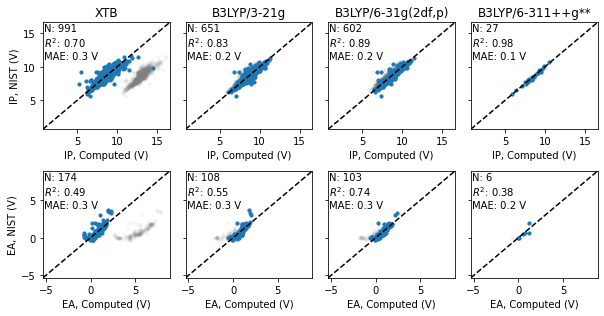

In [15]:
fig, axs = plt.subplots(2, 4, sharey='row', figsize=(8.5, 4.5))

for i, (label, nist) in enumerate(zip(['IP', 'EA'], [nist_ip, nist_ea])):
    
    # Get the range of the plot
    min_y = nist['value'].min() - 5
    max_y = nist['value'].max() + 5
    
    for ax, comp_data, title in zip(axs[i, :], [xtb, smb_nwchem, nob_nwchem, dfb_xtbvert_nwchem], 
                                    ['XTB', 'B3LYP/3-21g', 'B3LYP/6-31g(2df,p)', 'B3LYP/6-311++g**']):
        # Merge the datasets
        merged_data = comp_data.merge(nist, how='inner', on='inchi', suffixes=('', '_nist'))

        # Get IP data
        merged_data = merged_data[~merged_data[label].isnull()]
        
        # Get the correction
        y_corr, fit = correct_offset(merged_data['value'], merged_data[label])
        ax.scatter(y_corr, merged_data['value'], s=10)

        # Make the PvA graph
        l = ax.scatter(merged_data[label], merged_data['value'], c='gray', s=10, alpha=0.05, zorder=-1)
        c = l.get_facecolor()
        

        ax.set_xlim(min_y, max_y)
        ax.set_ylim(ax.get_xlim())
        ax.plot(ax.get_xlim(), ax.get_xlim(), 'k--')

        # Plot the statistics
        n = len(merged_data)
        ax.text(0.01, 0.99, f'N: {len(merged_data)}\n$R^2$: {r2_score(y_corr, merged_data["value"]):.2f}\n'
                f'MAE: {mean_absolute_error(y_corr, merged_data["value"]):.1f} V',
               transform=ax.transAxes, va='top', ha='left')

        ax.set_xlabel(f'{label}, Computed (V)')
        if i == 0:
            ax.set_title(title)
    
    axs[i, 0].set_ylabel(f'{label}, NIST (V)')

fig.tight_layout()
fig.savefig('figures/nist-pva-no-offset.svg')

Compute the error values

In [16]:
nist_errors = []
for label, nist in zip(['IP', 'EA'], [nist_ip, nist_ea]):
    for data, _, info in data_plus_styles:
        # Merge the datasets
        merged_data = data.merge(nist, how='inner', on='inchi', suffixes=('', '_nist'))
        merged_data = merged_data[~merged_data[label].isnull()]
        
        # Get the correction
        y_corr, fit = correct_offset(merged_data['value'], merged_data[label])
        
        for corr, values in zip([True, False], [merged_data[label], y_corr]):
            error = np.abs(merged_data['value'] - values)
            
            # Compute some error metrics
            results = {'level': info['label'], 'correction': corr, 'property': label, 'mae': error.mean(), 'std_ae': error.std()}
            for perc in [25, 50, 75]:
                results[f'error_{perc}'] = np.percentile(error, perc)
                results[f'cost_{perc}'] = np.percentile(merged_data['cum_wall_time'], perc)
            
            nist_errors.append(results)
nist_errors = pd.DataFrame(nist_errors)

In [17]:
nist_errors.to_csv('compared_to_nist.csv')

Plot them as a pareto surface

IP XTB 991 0.33671048365812795 0.01351946659353579
IP B3LYP/3-21g 651 0.2129077083588456 0.7260203516066206
IP B3LYP/3-21g: No ZPE 660 0.20871971563648464 0.27380062119005505
IP B3LYP/3-21g: XTB Vertical 843 0.23765820193156167 0.024972516710977867
IP B3LYP/3-21g: SMB Vertical 224 0.20981719048841874 0.2279064807331278
IP B3LYP/6-31g(2df,p) 602 0.16694537716180394 3.7765886310270984
IP B3LYP/6-31g(2df,p): No ZPE 634 0.16383281280668793 1.2336438955411007
IP B3LYP/6-311++g**: XTB Vertical 27 0.10763264319076737 0.10529048191421808
EA XTB 174 0.3457242963503587 0.009549065599953077
EA B3LYP/3-21g 108 0.30683212181056685 0.5751976870668769
EA B3LYP/3-21g: No ZPE 110 0.3023848178085111 0.22057389338570413
EA B3LYP/3-21g: XTB Vertical 167 0.3841122706781873 0.020287955683703746
EA B3LYP/3-21g: SMB Vertical 35 0.27950832535140824 0.28509886247771127
EA B3LYP/6-31g(2df,p) 103 0.26349752688596706 3.2153691222013134
EA B3LYP/6-31g(2df,p): No ZPE 110 0.2573146205082746 0.8826781839487529
EA B3LY

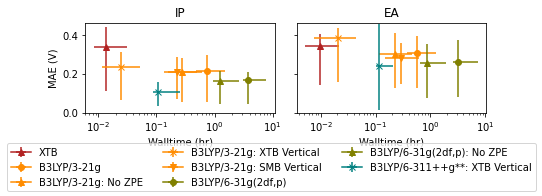

In [18]:
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(6.5, 2.75))

for ax, tag, nist in zip(axs, ['IP', 'EA'], [nist_ip, nist_ea]):
    for comp_data, _, styles in data_plus_styles:
        # Merge the datasets
        merged_data = comp_data.merge(nist, how='inner', on='inchi', suffixes=('', '_nist'))

        # Drop entries w/o runtimes available
        #  LW: Not sure why this is happenning
        merged_data = merged_data[~ merged_data[f'wall_time_{tag}'].isnull()]
        merged_data = merged_data[~ merged_data[[f'{tag}', f'value']].isnull().any(axis=1)]
        
        if len(merged_data) < 3:
            continue

        # Compute the offset
        y_corr, fit = correct_offset(merged_data['value'], merged_data[tag])
        merged_data[f'{tag}_corrected'] = y_corr

        # Compute the absolute error
        merged_data['abs_error'] = (merged_data[f'{tag}_corrected'] - merged_data['value']).abs()

        # Place the median on the chart with the error bars
        acc_median = np.mean(merged_data['abs_error'])
        acc_errorbar = np.std(merged_data['abs_error'])
        acc_errorbar = np.abs(np.percentile(merged_data['abs_error'], [25, 75]) - acc_median)
        cost_median = np.mean(merged_data[f'wall_time_{tag}']) / 3600
        cost_errorbar = np.std(merged_data[f'wall_time_{tag}']) / 3600
        cost_errorbar = np.abs(np.percentile(merged_data[f'wall_time_{tag}'], [25, 75]) - cost_median) / 3600

        print(tag, styles['label'], len(merged_data), acc_median, cost_median)
        ax.errorbar(cost_median, acc_median, yerr=acc_errorbar[:, None],
                    xerr=cost_errorbar[:, None], **styles)
    ax.set_title(tag)
        
    
    ax.set_xscale('log')
    #ax.set_yscale('log')
    ax.set_ylim(0, ax.get_ylim()[1])

    ax.set_xlabel('Walltime (hr)')

fig.legend(*ax.get_legend_handles_labels(), loc='lower center', ncol=3)
axs[0].set_ylabel('MAE (V)')
fig.tight_layout(rect=[0, 0.18, 1, 1])
fig.savefig('figures/pareto-plot_vs_nist.svg')

## Gaussian G4MP2
Gaussian G4MP2 is our gold standard for the best we can do with quantum chem

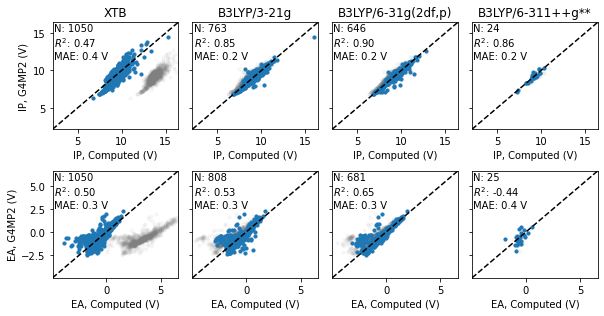

In [19]:
fig, axs = plt.subplots(2, 4, sharey='row', figsize=(8.5, 4.5))

for i, tag in enumerate(['IP', 'EA']):
    
    # Get the range of the plot
    min_y = gaussian[tag].min() - 2
    max_y = gaussian[tag].max() + 2

    
    for ax, comp_data, title in zip(axs[i, :], [xtb, smb_nwchem, nob_nwchem, dfb_xtbvert_nwchem], 
                                    ['XTB', 'B3LYP/3-21g', 'B3LYP/6-31g(2df,p)', 'B3LYP/6-311++g**']):
        # Merge the datasets
        merged_data = comp_data.merge(gaussian, how='inner', on='inchi_key', suffixes=('', '_g4mp2'))

        # Remove any inf/NaNs, etc
        merged_data = merged_data[~ merged_data[[tag, f'{tag}_g4mp2']].isnull().any(axis=1)]
        
        # Get the correction
        y_corr, fit = correct_offset(merged_data[f'{tag}_g4mp2'], merged_data[tag])
        ax.scatter(y_corr, merged_data[f'{tag}_g4mp2'], s=10)

        # Make the PvA graph
        l = ax.scatter(merged_data[tag], merged_data[f'{tag}_g4mp2'], c='gray', s=10, alpha=0.05, zorder=-1)
        c = l.get_facecolor()
        
        ax.set_xlim(min_y, max_y)
        ax.set_ylim(ax.get_xlim())
        ax.plot(ax.get_xlim(), ax.get_xlim(), 'k--')

        # Plot the statistics
        n = len(merged_data)
        ax.text(0.01, 0.99, f'N: {len(merged_data)}\n$R^2$: {r2_score(y_corr, merged_data[f"{tag}_g4mp2"]):.2f}\n'
                f'MAE: {mean_absolute_error(y_corr, merged_data[f"{tag}_g4mp2"]):.1f} V',
               transform=ax.transAxes, va='top', ha='left')

        ax.set_xlabel(f'{tag}, Computed (V)')
        if i == 0:
            ax.set_title(title)
    
    axs[i, 0].set_ylabel(f'{tag}, G4MP2 (V)')

fig.tight_layout()
fig.savefig('figures/g4mp2-pva-no-offset.svg')

IP XTB 1050 0.408894923967634 0.00958076585499698
IP B3LYP/3-21g 763 0.21410728312917224 0.3866454640730892
IP B3LYP/3-21g: No ZPE 782 0.2158729471373344 0.2571938416309301
IP B3LYP/3-21g: XTB Vertical 917 0.32243828514236383 0.019951201957326276
IP B3LYP/3-21g: SMB Vertical 256 0.303245008815368 0.1429753789313448
IP B3LYP/6-31g(2df,p) 646 0.15876672442189133 1.364248533573477
IP B3LYP/6-31g(2df,p): No ZPE 657 0.16765819857425557 0.7181278736882053
IP B3LYP/6-311++g**: XTB Vertical 24 0.2015113038889922 0.04900364230076472
EA XTB 1050 0.33669806162959914 0.012796104101150755
EA B3LYP/3-21g 808 0.2982463063940047 0.42291434310507786
EA B3LYP/3-21g: No ZPE 830 0.31241215556000906 0.30017080241768873
EA B3LYP/3-21g: XTB Vertical 936 0.34824292421816117 0.018123699611323513
EA B3LYP/3-21g: SMB Vertical 263 0.3698279348629174 0.13869004890391934
EA B3LYP/6-31g(2df,p) 681 0.2717872990169995 1.2724274238856041
EA B3LYP/6-31g(2df,p): No ZPE 690 0.27516206808543064 0.6988375946685504
EA B3LYP/

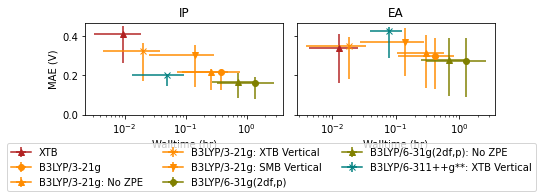

In [20]:
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(6.5, 2.75))

for ax, tag in zip(axs, ['IP', 'EA']):
    for comp_data, _, style in data_plus_styles:
        # Merge the datasets
        merged_data = comp_data.merge(gaussian, how='inner', on='inchi_key', suffixes=('', '_g4mp2'))

        # Drop entries w/o runtimes available
        #  LW: Not sure why this is happenning
        merged_data = merged_data[~ merged_data['cum_wall_time'].isnull()]
        merged_data = merged_data[~ merged_data[[f'{tag}', f'{tag}_g4mp2']].isnull().any(axis=1)]
        
        if len(merged_data) < 3:
            continue

        # Compute the offset
        y_corr, fit = correct_offset(merged_data[f'{tag}_g4mp2'], merged_data[tag])
        merged_data[f'{tag}_corrected'] = y_corr

        # Compute the absolute error
        merged_data['abs_error'] = (merged_data[f'{tag}_corrected'] - merged_data[f'{tag}_g4mp2']).abs()

        # Place the median on the chart with the error bars
        acc_median = np.mean(merged_data['abs_error'])
        acc_errorbar = np.abs(np.percentile(merged_data['abs_error'], [40, 60]) - acc_median)
        cost_median = np.mean(merged_data[f'wall_time_{tag}']) / 3600
        cost_errorbar = np.abs(np.percentile(merged_data[f'wall_time_{tag}'], [40, 60]) - cost_median) / 3600

        print(tag, style['label'], len(merged_data), acc_median, cost_median)
        ax.errorbar(cost_median, acc_median, yerr=acc_errorbar[:, None],
                    xerr=cost_errorbar[:, None], **style)
    ax.set_title(tag)
        
    
    ax.set_xscale('log')
    #ax.set_yscale('log')
    
    ax.set_ylim(0, ax.get_ylim()[1])

    ax.set_xlabel('Walltime (hr)')
    
fig.legend(*ax.get_legend_handles_labels(), loc='lower center', ncol=3)
axs[0].set_ylabel('MAE (V)')
fig.tight_layout(rect=[0, 0.17, 1, 1])
fig.savefig('figures/pareto-plot_vs_g4mp2.svg')

Condense the data to a single file

In [21]:
output = gaussian[['inchi_key', 'smiles', 'IP', 'EA']].rename(columns={'IP': 'IP_g4mp2', 'EA': 'EA_g4mp2'})
# Add in the other functions
for comp_data, tag, _ in tqdm(data_plus_styles):
    # Add the new data columns
    output = output.merge(comp_data[['inchi_key', 'IP', 'EA', 'wall_time_EA', 'wall_time_IP']], how='left', on='inchi_key')
    output.rename(columns={'wall_time_EA': f'wall_time_EA_{tag}', 'wall_time_IP': f'wall_time_IP_{tag}'}, inplace=True)
    
    # Calibrate the property
    for p in ['IP', 'EA']:
        fit_data = output[~output[[f'{p}_g4mp2', p]].isnull().any(axis=1)]
        y_corr, fit = correct_offset(fit_data[f'{p}_g4mp2'], fit_data[p])
        output[f'{p}_{tag}'] = y_corr
        output.drop(columns=[p], inplace=True)
        
output.to_csv('multifidelity-redox.csv', index=False)

100%|█████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00,  8.28it/s]


### Repeat the Process for the IP in Solvation
See how well we compare with the IP in ACN

IP XTB 510 0.4395892979150978 0.009974963879273607
IP B3LYP/3-21g 757 0.21195827329050823 0.38681297762810735
IP B3LYP/3-21g: No ZPE 775 0.21614334700887594 0.2572520547504493
EA XTB 510 0.37468161460006727 0.0125813053262
EA B3LYP/3-21g 806 0.26764012967089146 0.42335252377015353
EA B3LYP/3-21g: No ZPE 827 0.28143457347862627 0.30065191868378816


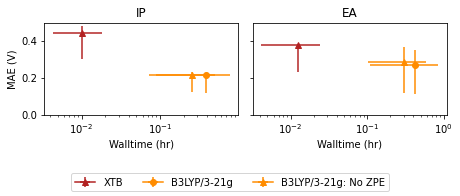

In [22]:
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(6.5, 2.75))

xsolv = gsolv = 'acetonitrile'
nsolv = 'acetntrl'
for ax, tag in zip(axs, ['IP', 'EA']):
    for comp_data, _, style in data_plus_styles:
        # Merge the datasets
        gcol = f'{tag}_{gsolv}'
        merged_data = comp_data.merge(gaussian.rename(columns={gcol: f'{gcol}_g4mp2'}), how='inner', on='inchi_key', suffixes=('', '_g4mp2'))
        
        # Make the names of the Gaussian and comparison column
        gcol = f'{tag}_{gsolv}_g4mp2'
        ccol = f'{tag}_{xsolv}' if 'XTB' in style['label'] else f'{tag}_{nsolv}'
        if ccol not in merged_data.columns or gcol not in merged_data:
            continue

        # Drop entries w/o runtimes available
        #  LW: Not sure why this is happenning
        merged_data = merged_data[~ merged_data['cum_wall_time'].isnull()]
        merged_data = merged_data[~ merged_data[[gcol, ccol]].isnull().any(axis=1)]
        
        if len(merged_data) < 3:
            continue

        # Compute the offset
        y_corr, fit = correct_offset(merged_data[gcol], merged_data[ccol])
        merged_data[f'{tag}_corrected'] = y_corr

        # Compute the absolute error
        merged_data['abs_error'] = (merged_data[f'{tag}_corrected'] - merged_data[gcol]).abs()

        # Place the median on the chart with the error bars
        acc_median = np.mean(merged_data['abs_error'])
        acc_errorbar = np.abs(np.percentile(merged_data['abs_error'], [40, 60]) - acc_median)
        cost_median = np.mean(merged_data[f'wall_time_{tag}']) / 3600
        cost_errorbar = np.abs(np.percentile(merged_data[f'wall_time_{tag}'], [40, 60]) - cost_median) / 3600

        print(tag, style['label'], len(merged_data), acc_median, cost_median)
        ax.errorbar(cost_median, acc_median, yerr=acc_errorbar[:, None],
                    xerr=cost_errorbar[:, None], **style)
    ax.set_title(tag)
        
    
    ax.set_xscale('log')
    #ax.set_yscale('log')
    
    ax.set_ylim(0, ax.get_ylim()[1])

    ax.set_xlabel('Walltime (hr)')
    
fig.legend(*ax.get_legend_handles_labels(), loc='lower center', ncol=3)
axs[0].set_ylabel('MAE (V)')
fig.tight_layout(rect=[0, 0.17, 1, 1])
fig.savefig('figures/pareto-plot_vs_g4mp2-acn.svg')